In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function
from torch.utils.data import DataLoader, Dataset
import numpy as np
from helper import *
import sklearn 

In [2]:
sequences = torch.from_numpy(getData("Data/rbcL_ordinal_encoding.txt", 50000)).float()

In [3]:
class Linear(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Linear, self).__init__()
        self.embedding = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size)
        )

    def forward(self, x):
        embedded_x = self.embedding(x)
        return embedded_x



model = Linear(sequences.shape[1], 256)
model.load_state_dict(torch.load('linear.pth'))
model.eval()

Linear(
  (embedding): Sequential(
    (0): Linear(in_features=300, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
  )
)

In [7]:
from sklearn.cluster import DBSCAN

def DBSCANOnEmbeddings(sequences_list, model, eps = 0.1 , leaf_size=10, p = 2, n_job = -1, normalize=True):
    # for each data point, put it into the model, get embeddings (10000, 1, 128)
    embeddings = []
    for seq in sequences_list:
        embedded_seq = model(seq.unsqueeze(0))
        if normalize:
            embedded_seq = sklearn.preprocessing.normalize(embedded_seq.detach().numpy())
        embeddings.append(embedded_seq)

    # reshape that into (10000, 128)
    embeddings = np.concatenate(embeddings, axis=0)
     
    # define Kmeans
    dbscan = DBSCAN(eps=eps, min_samples=2, leaf_size=leaf_size, p = p, n_jobs = n_job)
    
    # run Kmeans
    cluster_labels = dbscan.fit_predict(embeddings)

    # count labels to see if the clusters look okay ish
    unique_labels, label_counts = np.unique(cluster_labels, return_counts=True)

    for label, count in zip(unique_labels, label_counts):
        print(f"Label {label}: Count {count}")

    return cluster_labels, unique_labels



In [5]:
epsilons = np.arange(0.35, 0.45, 0.03)
print(epsilons)

[0.35 0.38 0.41 0.44]


In [6]:
leaf_sizes =  np.arange(20, 40, 5)
print(leaf_sizes)

[20 25 30 35]


In [9]:
cluster_labels, unique_labels = DBSCANOnEmbeddings(sequences, model, eps=0.35, leaf_size=20)

Label -1: Count 3080
Label 0: Count 744
Label 1: Count 18746
Label 2: Count 3
Label 3: Count 99
Label 4: Count 203
Label 5: Count 4
Label 6: Count 21
Label 7: Count 552
Label 8: Count 554
Label 9: Count 184
Label 10: Count 7
Label 11: Count 2
Label 12: Count 3
Label 13: Count 2747
Label 14: Count 16
Label 15: Count 801
Label 16: Count 3
Label 17: Count 493
Label 18: Count 125
Label 19: Count 120
Label 20: Count 2
Label 21: Count 972
Label 22: Count 24
Label 23: Count 23
Label 24: Count 31
Label 25: Count 17
Label 26: Count 3
Label 27: Count 15
Label 28: Count 1740
Label 29: Count 2
Label 30: Count 3
Label 31: Count 88
Label 32: Count 125
Label 33: Count 182
Label 34: Count 13
Label 35: Count 54
Label 36: Count 402
Label 37: Count 50
Label 38: Count 495
Label 39: Count 72
Label 40: Count 58
Label 41: Count 15
Label 42: Count 17
Label 43: Count 96
Label 44: Count 133
Label 45: Count 49
Label 46: Count 48
Label 47: Count 63
Label 48: Count 518
Label 49: Count 3
Label 50: Count 123
Label 5

In [17]:
cluster_labels_list_leaf  = []
unique_labels_list_leaf  = []
for leaf in leaf_sizes:
    cluster_labels_list = []
    unique_labels_list = []
    for eps in epsilons:
        cluster_labels, unique_labels = DBSCANOnEmbeddings(sequences, model, eps=eps, leaf_size=leaf)
        cluster_labels_list.append(cluster_labels)
        unique_labels_list.append(unique_labels)
    cluster_labels_list_leaf.append(cluster_labels_list)
    unique_labels_list_leaf.append(unique_labels_list)
    print(f"leafsize {leaf} done")    

leafsize 20 done
leafsize 25 done
leafsize 30 done
leafsize 35 done


# Plotting Number of Clusters

In [50]:
bar_labels = [f"{eps:.2g},{leaf:.2g}" for leaf in leaf_sizes for eps in epsilons]
print(bar_labels)

['0.35,20', '0.38,20', '0.41,20', '0.44,20', '0.35,25', '0.38,25', '0.41,25', '0.44,25', '0.35,30', '0.38,30', '0.41,30', '0.44,30', '0.35,35', '0.38,35', '0.41,35', '0.44,35']


In [51]:
bar_values = []
for i in range(len(leaf_sizes)):
    for j in range(len(epsilons)):
        bar_values.append(len(unique_labels_list_leaf[i][j]))
        print(f"{epsilons[j]} {leaf_sizes[i]}: {len(unique_labels_list_leaf[i][j])}")

0.35 20: 1525
0.38 20: 642
0.41000000000000003 20: 152
0.44000000000000006 20: 20
0.35 25: 1525
0.38 25: 642
0.41000000000000003 25: 152
0.44000000000000006 25: 20
0.35 30: 1525
0.38 30: 642
0.41000000000000003 30: 152
0.44000000000000006 30: 20
0.35 35: 1525
0.38 35: 642
0.41000000000000003 35: 152
0.44000000000000006 35: 20


In [52]:
print(bar_values)

[1525, 642, 152, 20, 1525, 642, 152, 20, 1525, 642, 152, 20, 1525, 642, 152, 20]


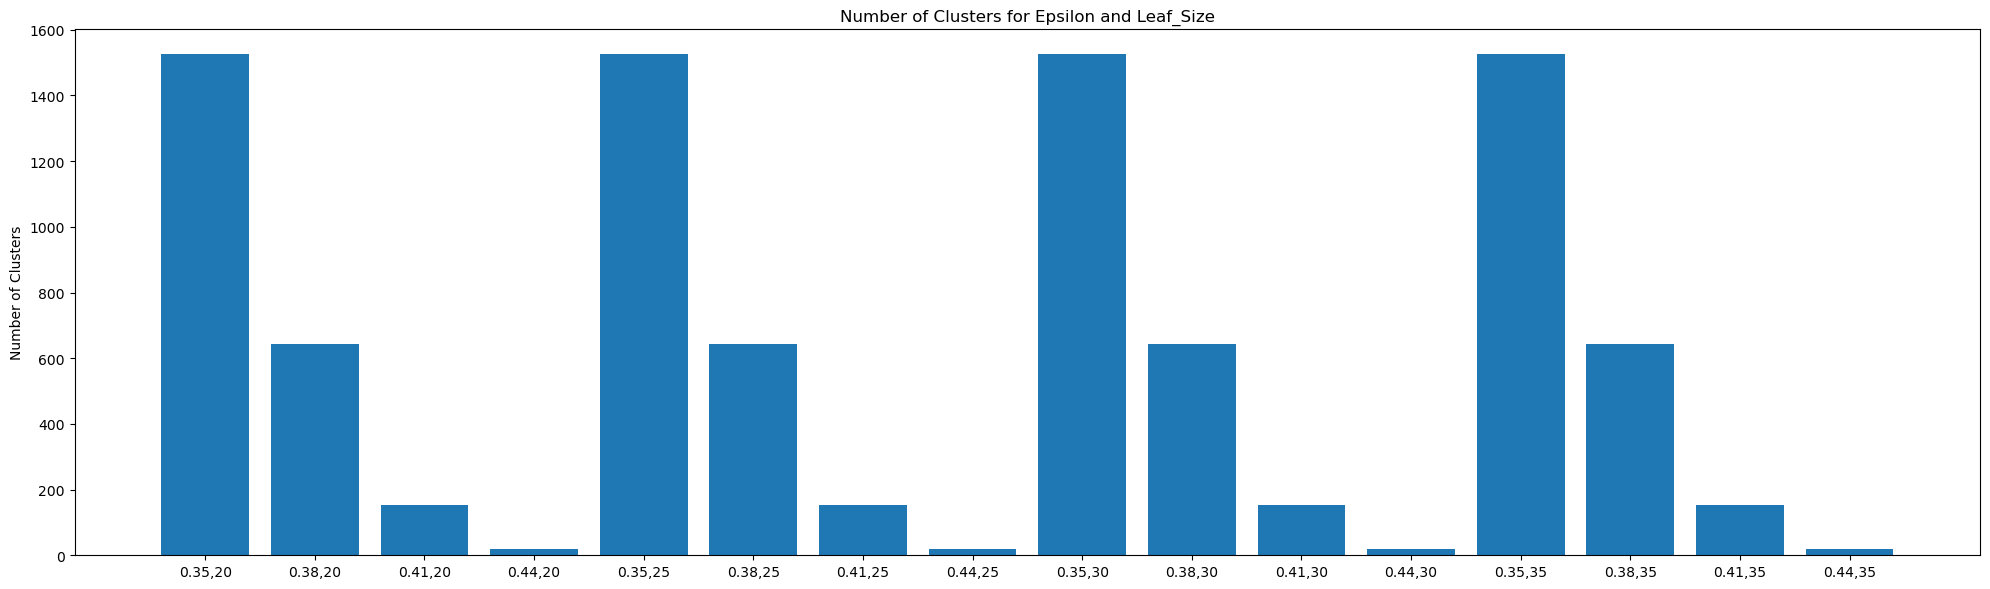

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 6)) 
plt.bar(range(len(bar_values)), bar_values, tick_label=bar_labels)

plt.title('Number of Clusters for Epsilon and Leaf_Size')
plt.ylabel('Number of Clusters')

plt.tight_layout()
plt.show()

# Plotting Max Cluster Size

In [48]:
bar_values = []
for i in range(len(leaf_sizes)):
    for j in range(len(epsilons)):
        
        counts = []
        unique_labels, label_counts = np.unique(cluster_labels_list_leaf[i][j], return_counts=True)
        for label, count in zip(unique_labels, label_counts):
            counts.append(count)

        bar_values.append(np.max(np.array(counts)))
        print(f"{epsilons[j]} {leaf_sizes[i]}: {np.max(np.array(counts))}")


0.35 20: 18746
0.38 20: 34157
0.41000000000000003 20: 42908
0.44000000000000006 20: 46997
0.35 25: 18746
0.38 25: 34157
0.41000000000000003 25: 42908
0.44000000000000006 25: 46997
0.35 30: 18746
0.38 30: 34157
0.41000000000000003 30: 42908
0.44000000000000006 30: 46997
0.35 35: 18746
0.38 35: 34157
0.41000000000000003 35: 42908
0.44000000000000006 35: 46997


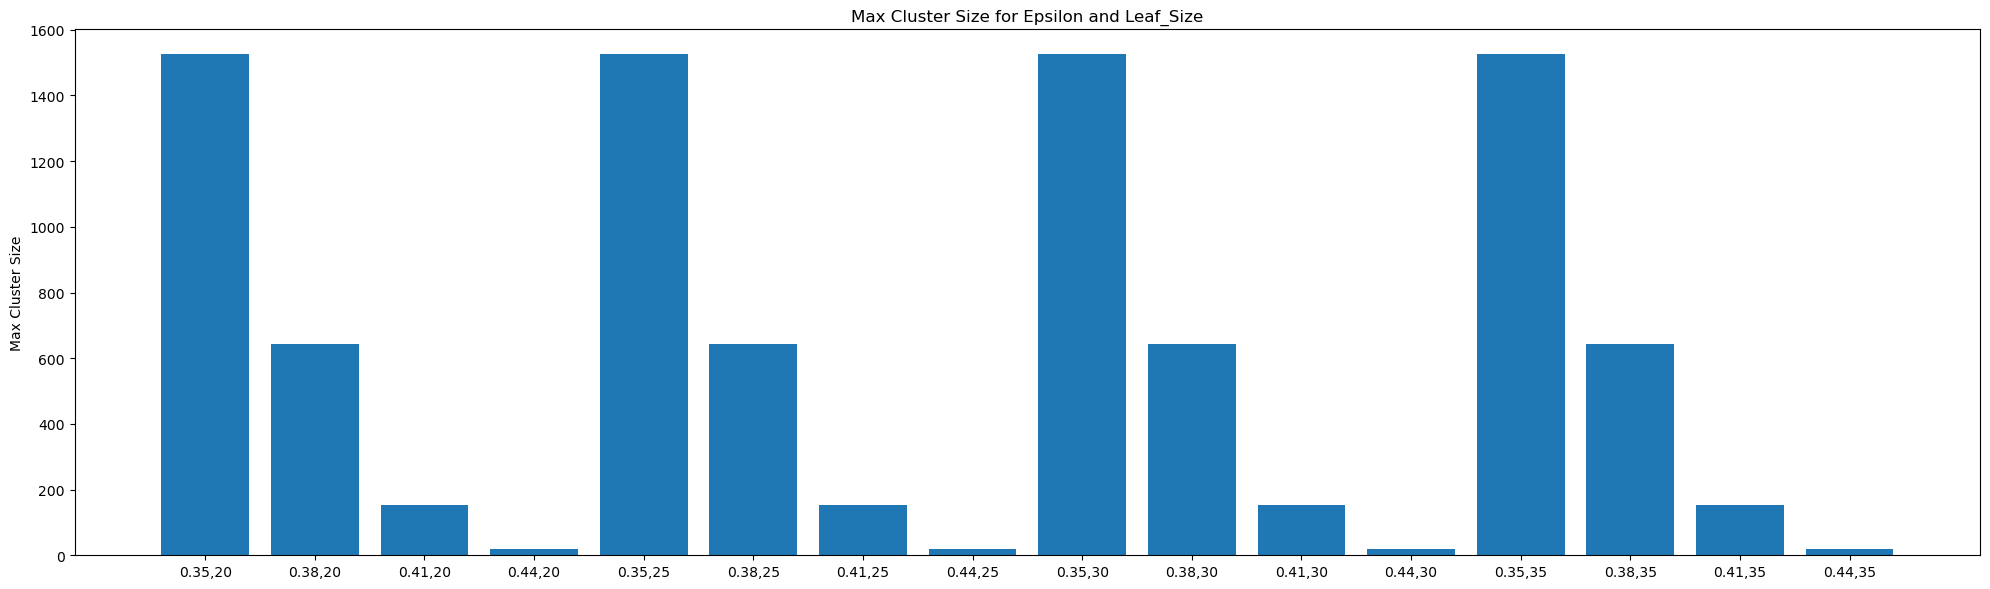

In [54]:
plt.figure(figsize=(20, 6)) 
plt.bar(range(len(bar_values)), bar_values, tick_label=bar_labels)

plt.title('Max Cluster Size for Epsilon and Leaf_Size')
plt.ylabel('Max Cluster Size')

plt.tight_layout()
plt.show()